## Predicting Stock Price using RNNs

Your task is to develop recurrent neural network models to predict the stock price of a company of your choice. The goal is to use stock price data (open, high, low, and close data) from the prior 60 days to predict the close price of the stock 5 days into the future.  

First, follow the steps below to download ~15 years of historical data on the stock price of your favorite company.

1. Go to [Yahoo Finance](https://finance.yahoo.com/).
2. Enter a stock symbol into the search field (e.g., AAPL for Apple).
3. Select it in the search results to view it.
4. Click Historical Data.
5. For the Time Period, please enter 01.01.2008 to 10.04.2023.
6. Make sure the Frequency is Daily.
6. Click Apply.
7. Click Download.

For this assignment, you are free to choose any company you like as long as it has 15 years of data (from 01.01.2008 to 10.04.2023). Examples of such companies include: Apple (AAPL), Google (GOOG), Amazon (AMZN), Nvidia (NVDA), Intel (INTC), Microsoft (MSFT), Adobe (ADBE), Netflix (NFLX), etc. You can also choose an ETF, such as the S&P 500 ETF (SPY).  


After you downloaded the historical stock data for a company of your choice, open the `.csv` file with Excel. You should be able to see seven columns: Date, Open, High, Low, Close, Adj Close, Volume.

You should also have 3968 rows in your dataset. The first row contains the headers, and the remaining 3967 rows contain daily stock prices. Note that stock prices are recorded on business days only (not weekends), so the first data point corresponds to 1.2.2008.

If everything looks good, close your Excel file and upload the `.csv` file on your Google Drive, so you can easily import it to your Colab Notebook.

## Importing the dataset

Mount your drive using the code below.

In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# The first time that you run this cell, you will need to authorize access in your drive.

Mounted at /content/drive


Replace the directory below with the path where your dataset is located.

In [2]:
# Define the directory where your ".csv" file resides on your google drive
# My path is the following (your path will be different):
fname = '/content/drive/MyDrive/ML & AI/HW3/F.csv'

Run the code block below to read the data and seperate header from numeric data lines.

In [3]:
f = open(fname)
data = f.read()
f.close()

data_lines = data.split('\n')     # Each line is 1 recording
header = data_lines[0].split(',') # Variable names are separated by commas
lines = data_lines[1:]        # Drop first line (it's a header)

print(header)
print(len(lines))

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
3967


Let's convert all of our data into a Numpy array:

In [4]:
import numpy as np

float_data = np.zeros((len(lines), 4))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:5]]
    float_data[i, :] = values
print(float_data.shape)
# Note that we only keep the following 4 columns: Open, High, Low, Close

(3967, 4)


You can plot the daily closing price of your stock over time as follows. Note that the closing price is **Column 3** in your dataset (columns are indexed 0, 1, 2, and 3). The dataset is named `float_data`.

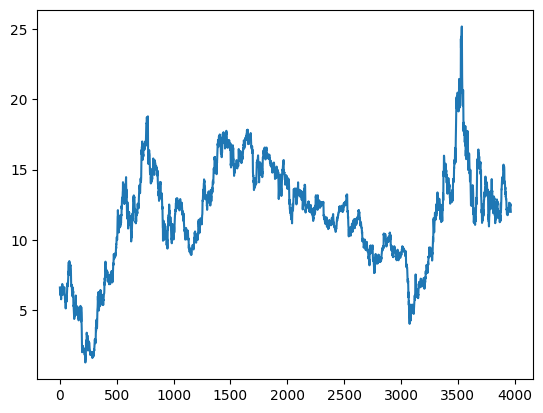

In [5]:
from matplotlib import pyplot as plt

close = float_data[:, 3]  # index 3 is close price
plt.plot(range(len(close)), close)

## Input normalization

Since the stock price data (Open, High, Low, Close) are positive numbers, we can divide each column by it's maximum value to make the values between 0 and 1.

In [6]:
float_data /= float_data.max(axis=0)

## Data generator

Similar to the Temperature Forecasting Example, we will need a data generator to automatically create batches of training, validation, and test data. We can use the same data generator function here (I copied it below).

The exact formulation of our problem is the following: given stock price data going as far back as `lookback` timesteps (a timestep is 1 day) and sampled every `steps` timesteps, can we predict the stock price in `delay` timesteps? In other words, given stock price data (Open, High, Low, Close) of the past 60 days, sampled every day, we aim to predict the close price in 5 days.

We have close to 4000 days of stock price data. Please use the first 2000 days as training data, the next 1000 days as validation data, and the remaining days as test data. Please use `batch_size` of 64.

In [7]:
import numpy as np

def generator(data, lookback, delay, min_index, max_index, random_sample, batch_size, step, target_index):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    # Out dara generator will generate data indefinitely, so we will have to tell Keras
    # how many batches constitute an epoch ('steps_per_epoch' and 'validation_steps' in model.fit)
    while 1:
        # For the training set (random_sample=True), randomly choose points in time
        if random_sample:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        # For the validation and test sets, choose batches of timesteps (in chronological order)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),       # Batch size
                           lookback // step, # Floor division (e.g., 5//2=2)
                           data.shape[-1]))  # Number of columns in data
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][target_index]
        yield samples, targets

## Question 1 (40 pts)

First, create instances of the data generator as `train_gen`, `val_gen`, and `test_gen`.

Then, develop a recurrent neural network with one `SimpleRNN` layer. For this question, include 128 units in the `SimpleRNN` layer.

Compile this model using the `Adam` optimizer and change the learning rate to `0.0001`. Use the appropriate loss function for this problem. During the training process, follow mean absolute percentage error or the `mape` metric on the train and validation sets. This will give you the percentage error for your stock price predictions.

Train your RNN model for 50 epochs. Given that our data generator creates batches of data indefinitely, we will have to tell Keras how many training (validation) batches constitute one training (validation) epoch. To do so, use `steps_per_epoch=20` and `validation_steps=14`.

Evaluate your trained RNN model on the test set. In `model.evaluate`, use `steps=14` to designate 14 batches of data as one test epoch. What is the mean absolute percentage error on the test set?

In [8]:
# prepare train, validation and test datasets
lookback = 60
step = 1
delay = 5
batch_size = 64
target_index = 3

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=2000,
                      random_sample=True,
                      step=step,
                      batch_size=batch_size,
                      target_index=target_index)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=2001,
                    max_index=3001,
                    random_sample=False,
                    step=step,
                    batch_size=batch_size,
                    target_index=target_index)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=3001,
                     max_index=None,
                     random_sample=False,
                     step=step,
                     batch_size=batch_size,
                     target_index=target_index)


# This is how many batches to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (3001 - 2001 - lookback) // batch_size

# This is how many batches to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 3001 - lookback) // batch_size

print(val_steps)
print(test_steps)

14
14


In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# prepare a RNN with one SimpleRNN layer
model1 = models.Sequential()
model1.add(layers.SimpleRNN(128, input_shape = (lookback // step, 4)))
model1.add(layers.Dense(1))


model1.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='mse',
              metrics=['mape'])

model1_history = model1.fit(train_gen,
                            steps_per_epoch=20,
                            epochs=50,
                            validation_data=val_gen,
                            validation_steps=14)

Epoch 1/50
20/20 [==============================] - 7s 68ms/step - loss: 0.4674 - mape: 123.7914 - val_loss: 0.0465 - val_mape: 49.6445
Epoch 2/50
20/20 [==============================] - 2s 88ms/step - loss: 0.0191 - mape: 35.9151 - val_loss: 0.0032 - val_mape: 11.4313
Epoch 3/50
20/20 [==============================] - 2s 88ms/step - loss: 0.0061 - mape: 21.9788 - val_loss: 0.0046 - val_mape: 14.4800
Epoch 4/50
20/20 [==============================] - 1s 48ms/step - loss: 0.0033 - mape: 16.3232 - val_loss: 0.0012 - val_mape: 6.5039
Epoch 5/50
20/20 [==============================] - 1s 57ms/step - loss: 0.0025 - mape: 14.0821 - val_loss: 8.6442e-04 - val_mape: 5.4694
Epoch 6/50
20/20 [==============================] - 2s 85ms/step - loss: 0.0024 - mape: 13.5590 - val_loss: 0.0012 - val_mape: 6.5870
Epoch 7/50
20/20 [==============================] - 2s 92ms/step - loss: 0.0020 - mape: 10.7647 - val_loss: 0.0010 - val_mape: 6.0242
Epoch 8/50
20/20 [==============================] - 1s

In [10]:
# evaluate the model on test data
model1.evaluate(test_gen, steps=14)

14/14 [==============================] - 0s 13ms/step - loss: 0.0022 - mape: 6.9684


[0.0022385769989341497, 6.9683637619018555]

Hence, the mean absolute percentage error on the test set is 6.96%.

## Question 2 (40 pts)

Develop a recurrent neural network with one `LSTM` layer. For this question, include 128 units in the `LSTM` layer.

Compile this model using the `Adam` optimizer and change the learning rate to `0.0001`. Use the appropriate loss function for this problem. During the training process, follow mean absolute percentage error or the `mape` metric on the train and validation sets. This will give you the percentage error for your stock price predictions.

Train your LSTM model for 50 epochs. Given that our data generator creates batches of data indefinitely, we will have to tell Keras how many training (validation) batches constitute one training (validation) epoch. To do so, use `steps_per_epoch=20` and `validation_steps=14`.

Evaluate your trained LSTM model on the test set. In `model.evaluate`, use `steps=14` to designate 14 batches of data as one test epoch. What is the mean absolute percentage error on the test set?

In [11]:
# prepare a RNN with one LSTM layer
model2 = models.Sequential()
model2.add(layers.LSTM(128, input_shape = (lookback // step, 4)))
model2.add(layers.Dense(1))


model2.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='mse',
              metrics=['mape'])

model2_history = model2.fit(train_gen,
                            steps_per_epoch=20,
                            epochs=50,
                            validation_data=val_gen,
                            validation_steps=14)

Epoch 1/50
20/20 [==============================] - 4s 36ms/step - loss: 0.1914 - mape: 83.9955 - val_loss: 0.0579 - val_mape: 53.9482
Epoch 2/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0277 - mape: 28.0538 - val_loss: 8.8243e-04 - val_mape: 5.7300
Epoch 3/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0033 - mape: 14.7679 - val_loss: 7.2341e-04 - val_mape: 5.1032
Epoch 4/50
20/20 [==============================] - 0s 18ms/step - loss: 0.0015 - mape: 9.6316 - val_loss: 4.0068e-04 - val_mape: 3.6860
Epoch 5/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0013 - mape: 9.3356 - val_loss: 5.5872e-04 - val_mape: 4.3663
Epoch 6/50
20/20 [==============================] - 0s 16ms/step - loss: 0.0014 - mape: 9.3898 - val_loss: 4.0841e-04 - val_mape: 3.6911
Epoch 7/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0013 - mape: 9.8257 - val_loss: 4.9181e-04 - val_mape: 4.0446
Epoch 8/50
20/20 [=======================

In [12]:
# evaluate the model on test data
model2.evaluate(test_gen, steps=14)

14/14 [==============================] - 0s 8ms/step - loss: 0.0024 - mape: 7.3483


[0.0024134889245033264, 7.3483052253723145]

Hence, the mean absolute percentage error on the test set is 7.34%.

## Question 3 (20 pts)

Your goal in this question is to employ your deep learning knowledge to improve your LSTM model. You can play with hyperparameters, stack LSTM layers, add dropout and recurrent dropout, alter the learning rate, try another optimizer such as `rmsprop`, and anything else that you think might help improve (i.e., decrease) the percentage error of your model. This is an open-ended question that aims to give you some experience with training a good deep learning model for a real-world problem. What you do in this exercise is called 'hyperparameter tuning'; this is usually the most time-consuming and the most expensive part of a deep learning project. In a sense, deep learning is babysitting a number of hyperparameters.

You do not need to show all of your work here. Please only include one model as your final model here. Explain (in words) what were some of the things that you tried and whether they were helpful to decrease the MAPE.

**Note:** For this open-ended question, you will receive full credit if you explain (or demonstrate) what you did to improve model performance via hyperparameter tuning.

**Note:** Make sure you run all of your code so that the output of each code block appears below it.  Once you are done, download your final `.ipynb` file (File -> Download .ipynb) and submit it on Canvas. Name your file as follows: LastName_FirstName_HW3.ipynb

In [13]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# prepare a RNN to improve LSTM model
model3 = models.Sequential()
model3.add(layers.LSTM(256, input_shape = (lookback // step, 4)))
model3.add(layers.Dense(1))


model3.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
              loss='mse',
              metrics=['mape'])

model3_history = model3.fit(train_gen,
                            steps_per_epoch=20,
                            epochs=50,
                            validation_data=val_gen,
                            validation_steps=14)

Epoch 1/50
20/20 [==============================] - 4s 40ms/step - loss: 0.0198 - mape: 22.6713 - val_loss: 3.4026e-04 - val_mape: 3.3792
Epoch 2/50
20/20 [==============================] - 0s 15ms/step - loss: 0.0018 - mape: 10.0360 - val_loss: 3.3491e-04 - val_mape: 3.3355
Epoch 3/50
20/20 [==============================] - 0s 17ms/step - loss: 0.0010 - mape: 8.1938 - val_loss: 3.4950e-04 - val_mape: 3.3972
Epoch 4/50
20/20 [==============================] - 0s 16ms/step - loss: 9.0045e-04 - mape: 7.6807 - val_loss: 3.2835e-04 - val_mape: 3.2845
Epoch 5/50
20/20 [==============================] - 0s 16ms/step - loss: 9.9439e-04 - mape: 8.0173 - val_loss: 3.2568e-04 - val_mape: 3.2676
Epoch 6/50
20/20 [==============================] - 0s 16ms/step - loss: 9.3542e-04 - mape: 7.2927 - val_loss: 3.3273e-04 - val_mape: 3.2986
Epoch 7/50
20/20 [==============================] - 0s 16ms/step - loss: 8.5449e-04 - mape: 6.9628 - val_loss: 3.6606e-04 - val_mape: 3.4549
Epoch 8/50
20/20 [=====

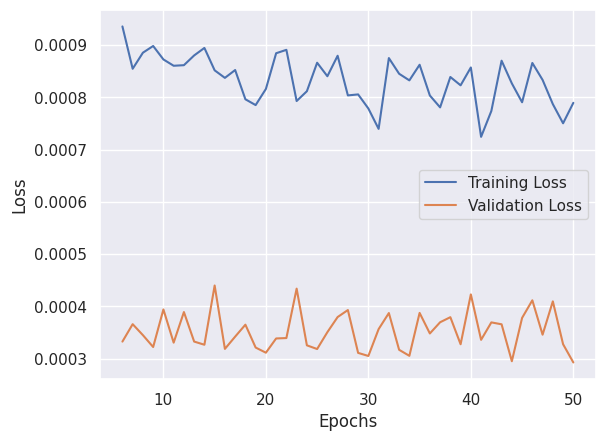

In [14]:
import seaborn as sns
sns.set()

# plot the training and validation losses after 5 epochs
train_loss3 = model3_history.history['loss']
train_mae3 = model3_history.history['mape']
val_loss3 = model3_history.history['val_loss']
val_mae3 = model3_history.history['val_mape']

epochs = range(1, len(train_loss3) + 1)

plt.plot(epochs[5:], train_loss3[5:], label = 'Training Loss')
plt.plot(epochs[5:], val_loss3[5:], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [15]:
model3.evaluate(test_gen, steps=14)

14/14 [==============================] - 0s 10ms/step - loss: 0.0017 - mape: 5.8566


[0.0016526187537238002, 5.856586456298828]

Explanation for hyperparameter tuning:

1) Adding another LSTM layer: The first thing I tried was adding another LSTM layer but with 64 nodes after the 128 node LSTM layer. To stack these recurrent layers, I had to use return_sequences=True in the first LSTM layer so it returns the full sequence of outputs. This method resulted in a slight increase in the ending validation MAPE as well as test MAPE. Based on this observation, I decided to tweak the model to have both LSTM layers use 64 nodes next.

2) Two LSTM layers each with 64 nodes: This method also resulted in a slight increase in the ending validation MAPE as well as test MAPE. Maybe two LSTM layers were not working well for this data. However, I wanted to explore further so I decided to change the nodes for the second LSTM layer to 32.

3) 64-32 LSTM layers: This method resulted in an even worse performance based on the observed increases in the ending validaiton MAPE and the test MAPE. Hence, I decided to keep only one layer for the following tweak, but decided to add a dropout and recurrent dropout of 0.3.

4) 128 LSTM with dropout and recurrent dropout: This method also did not improve validation MAPE and the test MAPE compared to the base model2. Hence, I decided to alter the learning rate and optimizer for the next tweak.

5) 128 LSTM with learning rate = 0.00001 for the RMSProp optimizer: This method also did not improve validation MAPE and the test MAPE compared to the base model2. For the next tweak, I tried increasing the learning rate to 0.0005 with Adam optimizer, along with increasing the nodes to 256.

6) 256 LSTM with learning rate = 0.0005 for the Adam optimizer: This method worked the best so far, and resulted in an improvement from the base model2. The test MAPE using this method was 5.85%. Hence, I am choosing this as my final model for this question.


To summarize, the final model I am choosing uses a 256 node LSTM layer and Adam optimizer with the learning rate of 0.0005. The test MAPE for this model was 5.85%.